# Marketing strategy for a new brand line

## Table of contents
<ul><font color=blue>
<li><a href="#problem">Question and problem definition</a></li>
<li><a href="#wrangle">Wrangle, prepare, cleanse the data</a></li>
<li><a href="#analyze">Analyze, identify patterns, and explore the data</a></li>
<li><a href="#transformation">Transform data before modelling</a></li>
<li><a href="#model">Model, predict and solve the problem</a></li>
<li><a href="#conclusion">Report and present the problem solving steps and final solution</a></li>
</ul>




<a id='problem'></a>
### Question and problem definition
Our client is a business platform which serves online marketing campaigns for many brands. One of the purposes of these campaigns is to incentivise online purchases of new products.
One of the brands that they work with has a catalogue of products with different prices, but none of them are within the range between 30 and 40 pounds. This particular brand wants to fill the gap in this price range by releasing a new line.
Our mission is to use existing data to evaluate how to best market the new line and predict the sales.
The dataset provided covered the period from 2018, July 1st to August 14th, but has several missing data points we need to provide in order to fit a model which will predict the sales in the following 2-3 weeks 

In [3]:
#This code is to import the libraries we will ptentially be using during the execution of the tasks I have been assigned to
# data analysis and wrangling
import pandas as pd
import pickle
import numpy as np
import random as rnd
from datetime import timedelta

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# statistics and machine learning
from scipy import stats
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler, RobustScaler
from fbprophet import Prophet
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# And ignores the Jupyter Notebook warnings in order to ameliorate the document readability. 

import warnings; warnings.simplefilter('ignore')

In [21]:
#Import of data into a dataframe called df
df=pd.read_pickle('case_study.pickle')
df.head()

,date,avg_hour,min_hour,max_hour,device_name,productBand,avg_price,total_products,num_orders,city,region,County,Country
1,2018-07-12,20.0,20,20,Mobile,between20and30,29.95,1.0,1,Redbourn,Hertfordshire,Hertfordshire,England
2,2018-08-05,22.0,22,22,Desktop and Laptop,between20and30,27.95,1.0,1,Bearsden,East Dunbartonshire,NaN,NaN
3,2018-07-13,14.0,14,14,Mobile,between20and30,27.95,1.0,1,Bearsden,East Dunbartonshire,NaN,NaN
5,2018-08-10,19.0,19,19,Tablet,lessThan10,9.95,1.0,1,Bearsden,East Dunbartonshire,NaN,NaN
6,2018-07-12,17.0,17,17,Desktop and Laptop,between20and30,29.95,1.0,1,Greenwich,Greenwich,NaN,NaN


<a id='wrangle'></a>
### Wrangle, prepare, cleanse the data
In this section we will be exploring the dataset to answer qustions like:
<ul>
<li>Which features are available in the dataset? </li>
<li>Which features are categorical and which ones are numerical?</li>
<li>Which features have missing values and how can we handle them? </li>
<li>which ones can we drop?</li>
    </ul>

In [22]:
#data exploration
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27091 entries, 1 to 32681
Data columns (total 13 columns):
date              27091 non-null object
avg_hour          27091 non-null float64
min_hour          27091 non-null int64
max_hour          27091 non-null int64
device_name       27091 non-null object
productBand       27091 non-null object
avg_price         25853 non-null float64
total_products    25100 non-null float64
num_orders        27091 non-null int64
city              27091 non-null object
region            27091 non-null object
County            10406 non-null object
Country           10406 non-null object
dtypes: float64(3), int64(3), object(7)
memory usage: 2.9+ MB


In [23]:
#converting type "object" to "datetime" for column "date" 
df['date'] = df['date'].astype('datetime64')
df.info()
#Sorting the values by 'date'
df.sort_values(by='date', inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27091 entries, 1 to 32681
Data columns (total 13 columns):
date              27091 non-null datetime64[ns]
avg_hour          27091 non-null float64
min_hour          27091 non-null int64
max_hour          27091 non-null int64
device_name       27091 non-null object
productBand       27091 non-null object
avg_price         25853 non-null float64
total_products    25100 non-null float64
num_orders        27091 non-null int64
city              27091 non-null object
region            27091 non-null object
County            10406 non-null object
Country           10406 non-null object
dtypes: datetime64[ns](1), float64(3), int64(3), object(6)
memory usage: 2.9+ MB


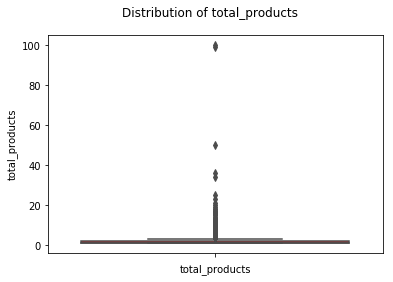

In [24]:
#Features "avg_price" and "orders_products" are missing roughly 2000 data points. Let's give a closer look to these 2 features
#Checking frequency distribution for 'orders_products'
#Checking distribution of 'orders_products'
plt.suptitle('Distribution of total_products')
#alternatively uncomment depending on the kind of plot you want to see
plt.xlabel('total_products')
#df['total_products'].plot.hist(figsize=(10,10), bins=100)
sns.boxplot(x=df['total_products'], orient='v',color='r')

In [25]:
#Uncomment if you want to drop possible outliers. 2 ways of detecting outliers (IQR and STdev based)
#shown below

#The box plot shows presence of outliers. To isolate and remove the outliers using the interquartile range (IQR):
Q1 =  df.total_products.quantile(0.25)
Q3 =  df.total_products.quantile(0.75)
IQR = Q3 - Q1
df =  df[~(( df.total_products < (Q1 - 1.5 * IQR)) |( df.total_products > (Q3 + 1.5 * IQR)))]

#""" The 'total_products' feature shows some outliers, so the following lines remove all the data that are outside
# its mean plus three times the associated standard deviation and show the initial rows of the resulting data frame. """

#total_products_limit =  df.orders_products.mean() + 3 *  (df.orders_products.std()) 
#df = df[ df.orders_products < total_products_limit]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25737 entries, 25080 to 6358
Data columns (total 13 columns):
date              25737 non-null datetime64[ns]
avg_hour          25737 non-null float64
min_hour          25737 non-null int64
max_hour          25737 non-null int64
device_name       25737 non-null object
productBand       25737 non-null object
avg_price         24501 non-null float64
total_products    23746 non-null float64
num_orders        25737 non-null int64
city              25737 non-null object
region            25737 non-null object
County            10120 non-null object
Country           10120 non-null object
dtypes: datetime64[ns](1), float64(3), int64(3), object(6)
memory usage: 2.7+ MB


I dropped roughly 1300 data points that is about 5% of the total. I decided to drop these possible 'outliers'

In [26]:
#Since the data from 'total_products' don't look to follow a normal distribution I decide to impute the 
#median (which is also the most common value (mode) of the total products sold each session) in the missing da-
#ta points
df['total_products'].fillna(df['total_products'].mode()[0], inplace=True)
df.describe()


,avg_hour,min_hour,max_hour,avg_price,total_products,num_orders
count,25737.000000,25737.000000,25737.000000,24501.000000,25737.000000,25737.000000
mean,14.766869,14.430431,15.093601,23.897686,1.259432,1.106073
std,5.923192,6.161134,5.988674,13.458082,0.539934,0.369746
min,0.000000,0.000000,0.000000,0.750000,1.000000,1.000000
25%,11.000000,11.000000,12.000000,16.950000,1.000000,1.000000
50%,15.000000,15.000000,16.000000,22.950000,1.000000,1.000000
75%,20.000000,20.000000,20.000000,28.950000,1.000000,1.000000
max,23.000000,23.000000,23.000000,80.950000,3.000000,10.000000


In [27]:
#our output is the total sales, which could be summarized as the product between # of products and # 
#of orders
df['orders_products']=df['total_products']*df['num_orders']

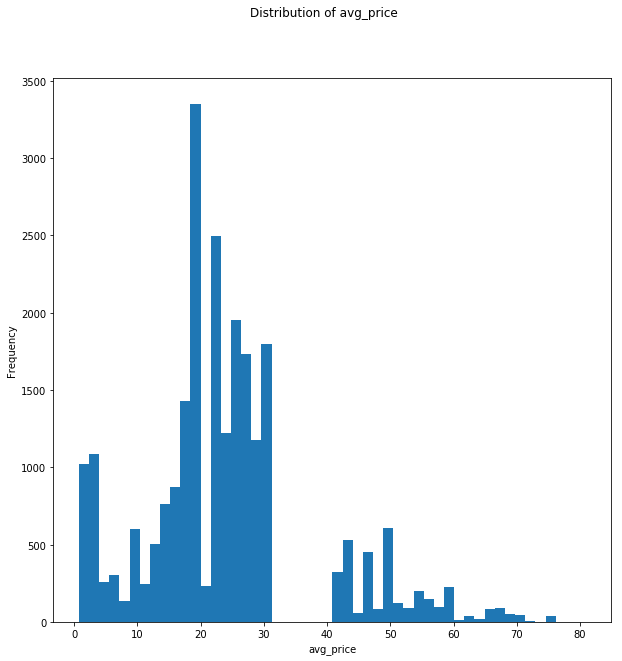

In [28]:
#Checking frequency distribution for average price
plt.suptitle('Distribution of avg_price')
plt.xlabel('avg_price')
df['avg_price'].plot.hist(figsize=(10,10), bins=50, label='avg_price')
plt.show()

In [29]:
#let's check the NaN values for 'avg_price'
df[df['avg_price'].isnull()]

,date,avg_hour,min_hour,max_hour,device_name,productBand,avg_price,total_products,num_orders,city,region,County,Country,orders_products
27594,2018-07-01,15.0,15,15,Tablet,price_missing,NaN,1.0,1,Sittingbourne,Kent,Kent,England,1.0
10659,2018-07-01,12.0,12,12,Mobile,price_missing,NaN,1.0,1,Hartlepool,Hartlepool,NaN,NaN,1.0
15349,2018-07-01,16.0,16,16,Desktop and Laptop,price_missing,NaN,1.0,1,Shrewsbury,Shropshire,Shropshire,England,1.0
20148,2018-07-01,13.0,13,13,Tablet,price_missing,NaN,1.0,1,Mansfield,Nottinghamshire,Nottinghamshire,England,1.0
15134,2018-07-01,20.0,20,20,Mobile,price_missing,NaN,1.0,1,Basildon,Essex,Essex,England,1.0
27675,2018-07-01,15.0,15,15,Tablet,price_missing,NaN,1.0,1,Great harwood,Lancashire,Lancashire,England,1.0
23445,2018-07-01,11.0,11,11,Desktop and Laptop,price_missing,NaN,1.0,1,Chapel house,Lancashire,Lancashire,England,1.0
6355,2018-07-01,16.0,16,16,Desktop and Laptop,price_missing,NaN,1.0,1,Chelmsford,Essex,Essex,England,1.0
23590,2018-07-01,8.0,8,8,Mobile,price_missing,NaN,1.0,1,Hyde,Tameside,NaN,NaN,1.0
13294,2018-07-01,22.0,22,22,Tablet,price_missing,NaN,1.0,1,Kilmarnock,East Ayrshire,NaN,NaN,1.0


In [31]:
#productBand was assigned as "pricemissing" where 'avg_price' is NaN. 'Nan' will be replaced with median values for 'avg_price' which is :
df['avg_price'].median()

22.95

In [32]:
#replacing nans with median values of avg_price
df['avg_price'].fillna(df['avg_price'].median(), inplace=True)
#and now let's replace 'price_missing' with the right band product
df['productBand'].replace('price_missing', 'between20and30', inplace=True)    

In [33]:
#The dataset contains a total of 27091 entries. Features "County" and "Country" may be dropped form the dataset since
#1.more than 50% of the rows entries are missing 
#2.they may not contribute to determine the sales
#I also don't need anymore 'total_products'and'num_orders'
df=df.drop(['County', 'Country','total_products','num_orders'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25737 entries, 25080 to 6358
Data columns (total 10 columns):
date               25737 non-null datetime64[ns]
avg_hour           25737 non-null float64
min_hour           25737 non-null int64
max_hour           25737 non-null int64
device_name        25737 non-null object
productBand        25737 non-null object
avg_price          25737 non-null float64
city               25737 non-null object
region             25737 non-null object
orders_products    25737 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 2.2+ MB


In [34]:
#Describing statistical metrics of numerical features
df.describe()

,avg_hour,min_hour,max_hour,avg_price,orders_products
count,25737.000000,25737.000000,25737.000000,25737.000000,25737.000000
mean,14.766869,14.430431,15.093601,23.852174,1.492287
std,5.923192,6.161134,5.988674,13.132499,1.244989
min,0.000000,0.000000,0.000000,0.750000,1.000000
25%,11.000000,11.000000,12.000000,17.450000,1.000000
50%,15.000000,15.000000,16.000000,22.950000,1.000000
75%,20.000000,20.000000,20.000000,27.950000,1.000000
max,23.000000,23.000000,23.000000,80.950000,10.000000


<a id='analyze'></a>
### Analyze, identify patterns, and explore the data
In this session I will be looking much deeper into data trends, exploring their statistical distribution and eventually correcting outliers and nans

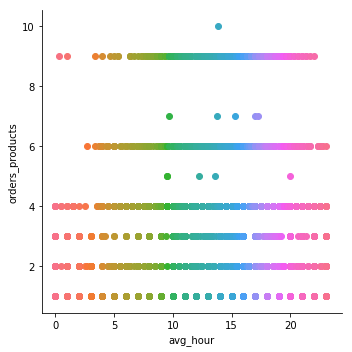

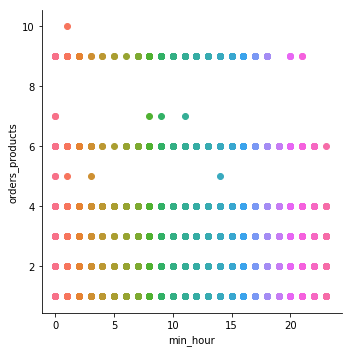

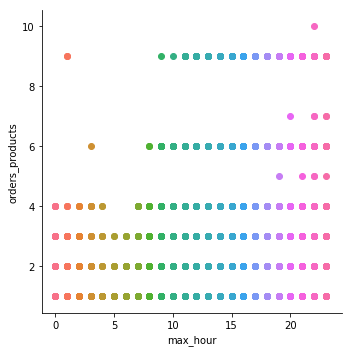

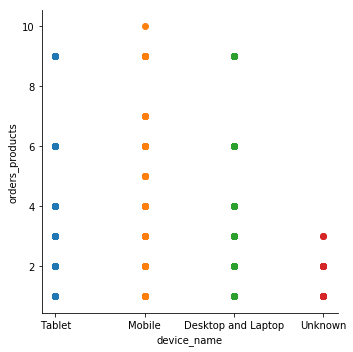

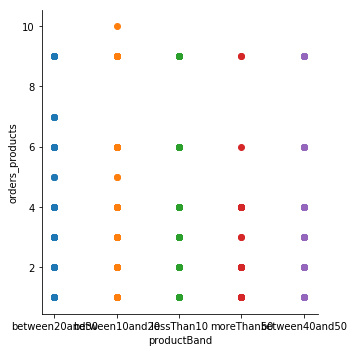

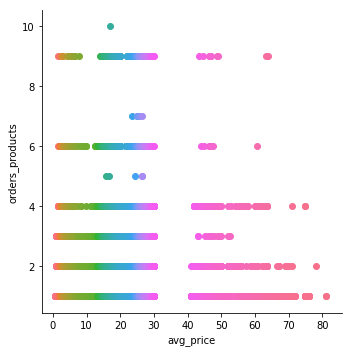

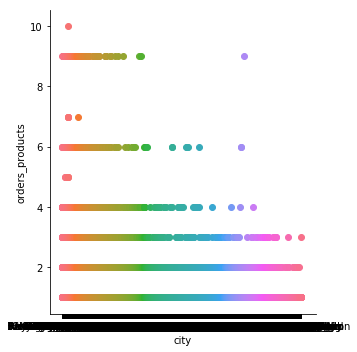

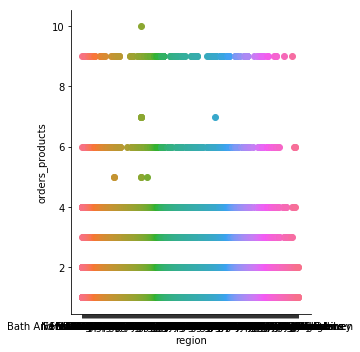

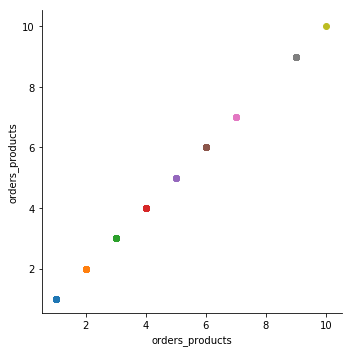

In [376]:
# Scatter plot for numeric features vs "total_products"
#numberical_features.remove("orders_products")
#df.columns."date","orders_products")
for i in (df.columns.drop("date")):
    sns.FacetGrid(df, hue=i, size=5).map(plt.scatter, i, "orders_products") 
plt.show()

In [37]:
#Let's give a look to the time-window  from August 8th to August 14th
df.loc[(df['date'] >= '2018-08-08') & (df['date'] <= '2018-08-14')]

,date,avg_hour,min_hour,max_hour,device_name,productBand,avg_price,city,region,orders_products
23228,2018-08-08,13.000000,13,13,Mobile,between40and50,42.950000,Oswestry,Shropshire,1.0
3016,2018-08-08,15.000000,15,15,Tablet,moreThan50,70.990000,Norwich,Norfolk,1.0
3047,2018-08-08,20.000000,20,20,Tablet,between20and30,24.950000,Norwich,Norfolk,1.0
31333,2018-08-08,19.000000,19,19,Desktop and Laptop,between10and20,19.950000,Barcombe,East Sussex,1.0
12697,2018-08-08,16.000000,16,16,Mobile,between10and20,19.950000,Reading,Reading,1.0
1034,2018-08-08,5.500000,0,11,Mobile,lessThan10,1.970000,Glasgow,Glasgow City,2.0
21136,2018-08-08,16.000000,16,16,Mobile,between20and30,22.950000,Maidenhead,Windsor And Maidenhead,1.0
21313,2018-08-08,13.000000,13,13,Mobile,lessThan10,2.970000,Taunton,Somerset,1.0
12653,2018-08-08,16.000000,16,16,Mobile,between20and30,22.950000,Reading,Reading,1.0
29016,2018-08-08,0.000000,0,0,Mobile,moreThan50,65.950000,Newry,Newry mourne and down,1.0


In [38]:
#I noticed 2018-08-14 have a weird trend compare to the other days (avg_hour,min_hour, max_hour are all 
#equal to 0 and the numbers of rows(=sales) is also lower than the other previous days). I decided to 
#not consider data coming from this date
df= df[ df['date'] != '2018-08-14']

In [39]:
#describing statistical distribution of categorical features
df.describe(include=['O'])

,device_name,productBand,city,region
count,25733,25733,25733,25733
unique,4,5,3274,217
top,Mobile,between20and30,Birmingham,Essex
freq,14618,11845,261,624


In [71]:
#let's check the categories of 'device_name'
df['device_name'].unique()

array(['Tablet', 'Mobile', 'Desktop and Laptop', 'Unknown'], dtype=object)

In [40]:
#one device_name category is "Unknown". Let's check how many entries are present for each device_name
df.groupby(['device_name']).count()

,date,avg_hour,min_hour,max_hour,productBand,avg_price,city,region,orders_products
device_name,,,,,,,,,
Desktop and Laptop,7005,7005,7005,7005,7005,7005,7005,7005,7005
Mobile,14618,14618,14618,14618,14618,14618,14618,14618,14618
Tablet,3991,3991,3991,3991,3991,3991,3991,3991,3991
Unknown,119,119,119,119,119,119,119,119,119


In [41]:
#I decided to not consider the "Unknown" category for our analysis, since it has only 119 entries
df= df[ df['device_name'] != 'Unknown']

In [42]:
#I decided to drop: 
#-"region" and keep "city" as geographic feature
#-"productBand" because it's a redundant information with "avg_price" 
#-'min_hour',because it's redundant with "avg_hour" and did not show pattern during data visualization "
df=df.drop(['region','min_hour','productBand'], axis=1)

In [43]:
#I assume the frequency of sales depends on the day of the week. Therefore I will create a new variable ('day_of_week')
#for the day of the week 
df['day_of_week']=df['date'].dt.dayofweek

I will now create a new category of average price, to simulate the introduction of the new line of products that is going to be sold at prices between 30 and 40 pounds. The new category will have a similar distribution to the existing feature "avg_price"

In [44]:
df['avg_price'].describe()

count    25614.000000
mean        23.868967
std         13.141080
min          0.750000
25%         17.450000
50%         22.950000
75%         27.950000
max         80.950000
Name: avg_price, dtype: float64

In [21]:
# using Shapiro normality test
stat, p = shapiro(df.avg_price)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=nan, p=1.000
Sample looks Gaussian (fail to reject H0)


In [77]:
#I am now creatin a new columns for new average prices of products. This serie of value will have a 
#normal distribution based on the mean and standard deviation of the existing 'avg_price' data
df['avg_price_random_30to40'] =np.random.normal(23.868967 ,13.141080, 25614)

In [78]:
#The 'avg_price_random_30to40' feature look to have negative values, which I am going to replace with 
#the mean for this feature
avg_positive=[]
for i in df['avg_price_random_30to40']:
    if i >0:
           avg_positive.append(i)
    else:
           avg_positive.append(np.random.uniform(low=0.75, high=2.5))
#replacing the vg_price_random_30to40' column with the new values                             
df['avg_price_random_30to40']=avg_positive

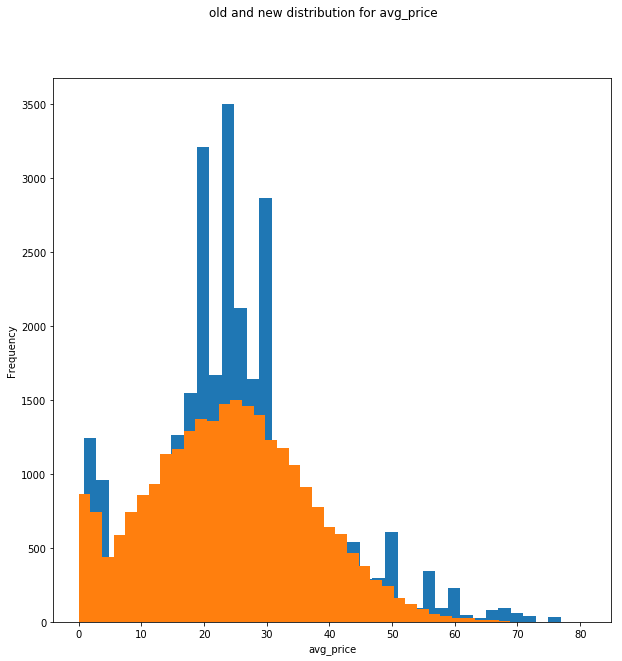

In [35]:
#let's compare the 2 distribution of average prices of products
plt.suptitle('old and new distribution for avg_price')
plt.xlabel('avg_price')
df['avg_price'].plot.hist(figsize=(10,10), bins=40)
df['avg_price_random_30to40'].plot.hist(figsize=(10,10), bins=40)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25614 entries, 25080 to 20094
Data columns (total 9 columns):
date                       25614 non-null datetime64[ns]
avg_hour                   25614 non-null float64
max_hour                   25614 non-null int64
device_name                25614 non-null object
avg_price                  25614 non-null float64
city                       25614 non-null object
orders_products            25614 non-null float64
day_of_week                25614 non-null int64
avg_price_random_30to40    25614 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 2.0+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B1A9E70A90>,
      dtype=object)

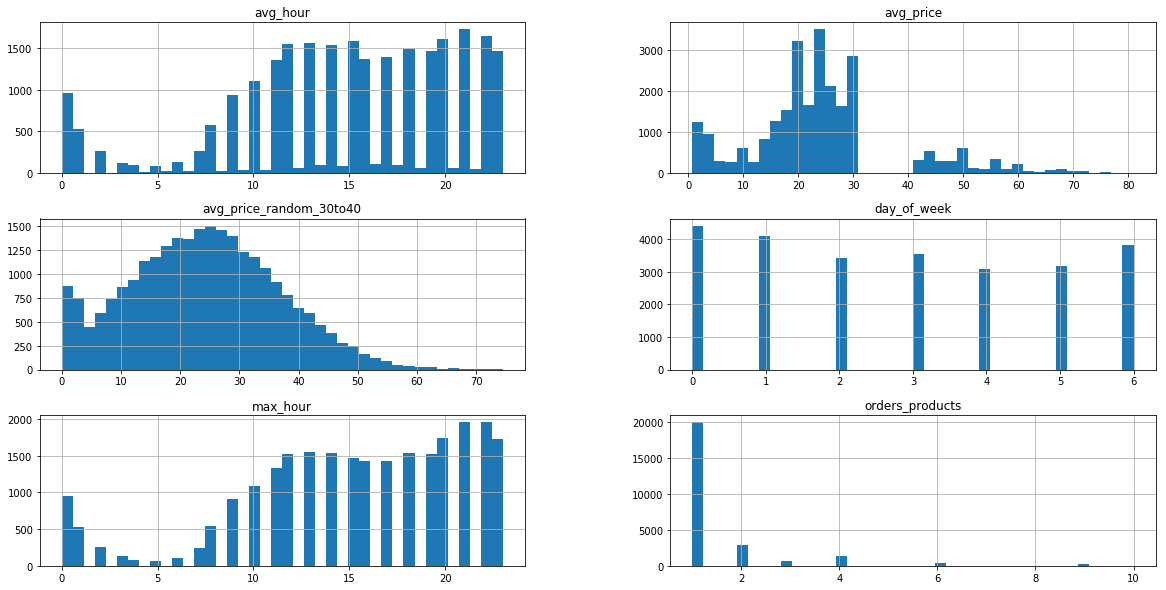

In [37]:
df.hist(bins = 40, figsize = (20, 10))

<a id='transformation'></a>
### Dataset transformation
I will now transform categorical features and transform skewed numberical ones

In [79]:
#LabelEncoding using Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder, Imputer
from scipy.stats import skew

# Label encoding class
class labenc(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        label = LabelEncoder()
        X['day_of_week']=label.fit_transform(X['day_of_week'])
        #X['productBand']=label.fit_transform(X['productBand'])
        return X
# Skewness transform class
# Log transform of the skewed numerical features to lessen impact of outliers
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
class skewness(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        skewness = X.select_dtypes(include=[np.number]).apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= 1].index
        X[skewness_features] = np.log1p(X[skewness_features])
        return X

# One hot encoding class
class onehotenc(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X = pd.get_dummies(X)
        return X

In [80]:
# Creating a copy of the full dataset
df_X=df.drop(['orders_products'], axis=1)
dataFullCopy = df_X.copy()

# Creating a new fata with aplied transformations using sklearn Pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('labenc',labenc()),('skewness',skewness()),('onehotenc',onehotenc())])
dataPipeline = pipeline.fit_transform(dataFullCopy)
df.shape, dataPipeline.shape

((25614, 9), (25614, 3277))

In [87]:
dataPipeline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25614 entries, 25080 to 20094
Columns: 3278 entries, date to orders_products
dtypes: datetime64[ns](1), float64(4), int64(2), uint8(3271)
memory usage: 81.5 MB


<a id='model'></a>
### Model, predict and solve the problem
Now I will focus on answering the questions for this challenge through use of machine learning tools.
In this section I will:
<ol type="1">
<li>Build a predictive model for the sales from August 14th to August 31st</li>
<li>Simulate the sales after introducing the new brand line which has price range between 30 and 40s pound</li>
<li>Predict future sales using the new line of price ranges</li>
    </ol>
 

1.Build a predictive model for the sales from August 14th to August 31st

In [90]:
#dataPipeline.total_products=dataPipeline.total_products.astype('int64')
dataPipeline['orders_products']=df.orders_products

Text(0,0.5,'Daily sales')

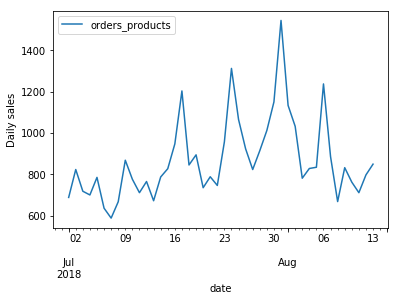

In [93]:
#Let's give a look how the time-serie of daily sales looks like
daily_trend=pd.DataFrame(dataPipeline.groupby(['date']).agg({'orders_products':'sum'}))
daily_trend.plot()
plt.ylabel("Daily sales")


In [42]:
dataPipeline.orders_products.unique()

array([ 1.,  3.,  4.,  2.,  6.,  9.,  5.,  7., 10.])

In [43]:
#I will train Prophet machine learning algorithm on sales data
data_prophet = daily_trend.copy()
data_prophet = pd.DataFrame(data_prophet)
data_prophet.reset_index(drop=False, inplace=True)
data_prophet.columns =['ds','y']
data_prophet

,ds,y
0,2018-07-01,689.0
1,2018-07-02,824.0
2,2018-07-03,719.0
3,2018-07-04,701.0
4,2018-07-05,786.0
5,2018-07-06,637.0
6,2018-07-07,589.0
7,2018-07-08,668.0
8,2018-07-09,869.0
9,2018-07-10,777.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


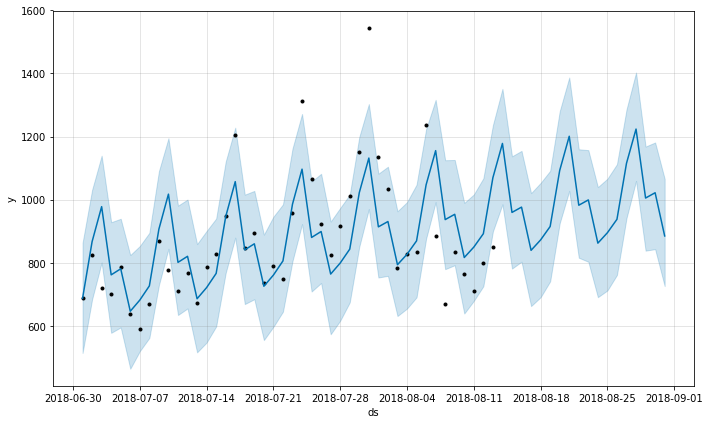

In [44]:
#Using trained Prophet model to predict the fututre 18 days
m = Prophet()
m.fit(data_prophet)
future = m.make_future_dataframe(periods=18, freq='D')
forecast = m.predict(future)
m.plot(forecast)
plt.savefig('forecast.png', bbox_inches='tight')
plt.show()

#daily_trend.plot()

There is a clear trend of growth for the sales with time. 

In [43]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [46]:
#now let's see the values for the future 18 days
forecasted_values = forecast[['ds', 'yhat']].tail(18)
forecasted_values = forecasted_values.set_index('ds')
forecasted_values.columns = ['y']
forecasted_values

,y
ds,
2018-08-14,1178.161993
2018-08-15,959.562471
2018-08-16,976.325760
2018-08-17,839.383004
2018-08-18,872.399639
2018-08-19,914.898606
2018-08-20,1092.470458
2018-08-21,1200.948963
2018-08-22,982.349440


In [47]:
#calculating total of sales
sum(forecasted_values['y'])

17961.641631861417

In [48]:
#Our final goal is to see if the new brand line is going to be beneficial for the sales
#let's calculate how many products the client has sold in the time window of the given dataset and without
#using the new bran line
sum(dataPipeline['orders_products'])


38262.0

In [168]:
#And let's calculate the revenue for the same as above
Total_revenue=dataPipeline.orders_products*dataPipeline.avg_price
sum(Total_revenue)

878080.3618612614

That was the result for the pre-existing brand lines of product. We aim to see if the sales change when we introduce a new line that has new price range. Before that we need to build a model that predict the sales based on the preexisting features:

Our training dataset has too many features, which require scaling

In [85]:
dataPipeline.describe()

,avg_hour,max_hour,avg_price,day_of_week,avg_price_random_30to40,device_name_Desktop and Laptop,device_name_Mobile,device_name_Tablet,city_Abberley,city_Abbey hey,...,city_Yatton,city_Yeadon,city_Yeaveley,city_Yelvertoft,city_Yelverton,city_Yeovil,city_Ynyslas,city_York,city_Yorkley,orders_products
count,25614.000000,25614.000000,25614.000000,25614.00000,25614.000000,25614.000000,25614.000000,25614.000000,25614.000000,25614.000000,...,25614.000000,25614.000000,25614.000000,25614.000000,25614.000000,25614.000000,25614.000000,25614.000000,25614.000000,25614.000000
mean,14.767155,15.095456,23.868967,2.84485,24.041999,0.273483,0.570704,0.155813,0.000078,0.000039,...,0.000039,0.000234,0.000078,0.000078,0.000156,0.001054,0.000039,0.002616,0.000078,1.493792
std,5.921944,5.987694,13.141080,2.06583,12.642498,0.445755,0.494985,0.362685,0.008836,0.006248,...,0.006248,0.015304,0.008836,0.008836,0.012496,0.032451,0.006248,0.051079,0.008836,1.247439
min,0.000000,0.000000,0.750000,0.00000,0.004480,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,11.000000,12.000000,17.450000,1.00000,14.868756,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,15.000000,16.000000,22.950000,3.00000,23.812313,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,20.000000,20.000000,27.950000,5.00000,32.717678,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,23.000000,23.000000,80.950000,6.00000,76.008073,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000


In [110]:
dataPipeline=dataPipeline.dropna()

In [185]:
# Using Robust Scaler to transform data
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()

#Now I want to build a predictive model for the sales, based on the dataset features.
#I decided to split some redundant features like 'productBand'(we already have 'avg_price',
#'min_hour'and 'max_hour'(we have 'avg_hour', that has a similar distrobution as shown by histogram plots).
#I will split the time-series between training and testing dataset in a ratio 2:1. The model will be
#therefore trained on the a period of 1 month..
dataPipeline_train =  dataPipeline.loc[( dataPipeline['date'] >= '2018-07-01')|( dataPipeline['date']<= '2018-07-31')]
Y_train =  dataPipeline_train['orders_products']
X_train =  dataPipeline_train.drop(['orders_products', 'date', 'avg_hour','avg_price_random_30to40'], axis=1)  
X_train_scaled = robust_scaler.fit(X_train).transform(X_train)
#and test on the following 14 days
dataPipeline_test =  dataPipeline.loc[( dataPipeline['date'] >= '2018-08-01')|( dataPipeline['date']< '2018-08-14')]
Y_test =  dataPipeline_test['orders_products']#The box plot shows presence of outliers. To isolate and remove the outliers using the interquartile range (IQR):
X_test =  dataPipeline_test.drop(['orders_products', 'date', 'avg_hour','avg_price_random_30to40'], axis=1)
X_test_scaled = robust_scaler.transform(X_test)
X_new_line = dataPipeline.drop(['orders_products', 'date', 'avg_hour','avg_price'], axis=1)
X_new_line_scaled = robust_scaler.transform(X_new_line)

In [186]:
# Choose the number of principle components such that 95% of the variance is retained
from sklearn.decomposition import RandomizedPCA 
pca = PCA(n_components=500)
X_train_scaled = pca.fit_transform(X_train_scaled)
varPCA = np.round(pca.explained_variance_ratio_*100, decimals = 1)
X_test_scaled = pca.fit_transform(X_test_scaled)
X_new_line_scaled = pca.fit_transform(X_new_line_scaled)

In [199]:
#Let's evaluate which machine learning algorythm is more accurate using accuracy as metric

models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('CRT', DecisionTreeClassifier(random_state = 46)))
models.append(('CRF', RandomForestClassifier(random_state = 46)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('SV', SVC()))
models.append(('QBC', GradientBoostingClassifier()))
models.append(('GNB', GaussianNB()))
#models.append(('CRT', DecisionTreeRegressor()))
#models.append(('RDF', RandomForestRegressor()))
#models.append(('LNR', LinearRegression()))
#models.append(('RID', Ridge()))
#models.append(('LAR', Lasso()))


In [200]:
# evaluate each model in turn

results = []
names = []
for name, model in models:
    
    model.fit(X_train_scaled,Y_train)
    Y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(Y_test, Y_pred)
    
    #RMSE = rmse(Y_test, Y_pred)
    #print("- {} : mean : {:.6f}, std : {:4f}".format(name, score.mean(),score.std())) 
    results.append(accuracy)
   
    names.append(name)
    msg = "%s: %f" % (name, accuracy.mean())
   
    print(msg)

KNN: 0.790466
CRT: 0.582728
CRF: 0.723315
LDA: 0.757554
SV: 0.779222
QBC: 0.773600
GNB: 0.133208


In [203]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
KNN = KNeighborsClassifier()
param_search = {'n_neighbors': (8,9)}

my_cv = TimeSeriesSplit(n_splits=2).split(X_train)
gsearch = GridSearchCV(estimator=KNN, cv=my_cv,
                        param_grid=param_search)
gsearch.fit(X_train_scaled, Y_train)


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002B1B41C2468>,
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': (8, 9)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [208]:
#Decision Tree algorithm is giving the best accuracy. Let's create the regressor for it and call it DTR
KNN = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
KNN.fit(X_train_scaled, Y_train)
print(KNN.score(X_test_scaled, Y_test))
Y_pred=KNN.predict(X_test_scaled)

0.790466151323495


In [244]:
print(f1_score(Y_test, Y_pred, average="macro"))
print(precision_score(Y_test, Y_pred, average="macro"))
print(recall_score(Y_test, Y_pred, average="macro"))  

0.22639345918885667
0.4228616170681967
0.20847745060141865


In [209]:
#and I will predict the sales for this new line using the previously built and trained regressor 'DTR'
Y_pred_newline = KNN.predict(X_new_line_scaled)   

In [210]:
#let's calculate the total sales for this new brand line
sum(Y_pred_newline)

27170.0

In [167]:
#and also the revenue
Total_revenue=Y_pred_newline*dataPipeline.avg_price_random_30to40
sum(Total_revenue)

788014.8424985241

3.Predict future sales using the new line of price ranges

In [169]:
#let's add the new predicted total sales to the initial dataframe in a column named 'total_products_new_line'
dataPipeline['orders_products_new_line']=Y_pred_newline
Y_pred_newline

array([1., 1., 1., ..., 1., 2., 1.])

In [170]:
daily_trend_new_line=pd.DataFrame(dataPipeline.groupby(['date']).agg({'orders_products_new_line':'sum'}))
daily_trend_new_line

,orders_products_new_line
date,
2018-07-01,655.0
2018-07-02,723.0
2018-07-03,646.0
2018-07-04,579.0
2018-07-05,652.0
2018-07-06,559.0
2018-07-07,500.0
2018-07-08,664.0
2018-07-09,701.0


In [171]:
#I will train Prophet machine learning algorythm on the new dataset
data_prophet_new = daily_trend_new_line.copy()
data_prophet_new = pd.DataFrame(data_prophet_new)
data_prophet_new.reset_index(drop=False, inplace=True)
data_prophet_new.columns =['ds','y']
data_prophet_new.sum()

y    32662.0
dtype: float64

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


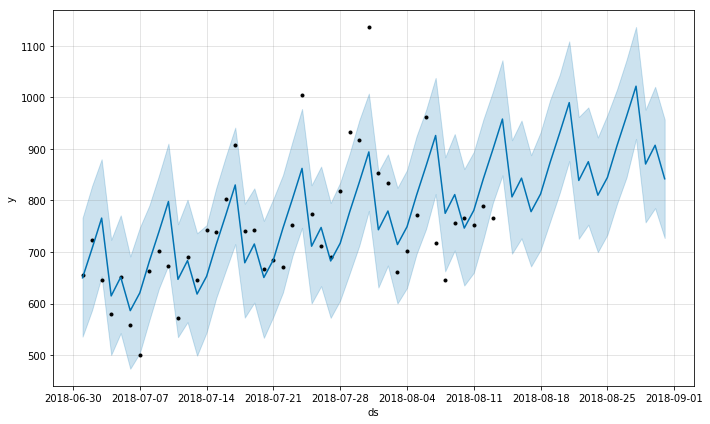

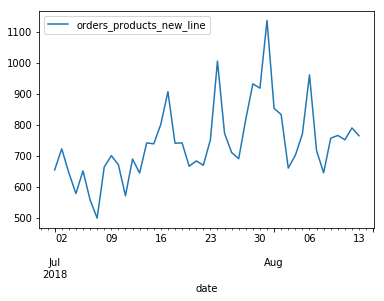

In [172]:
#Using trained Prophet model to predict the future 18 days
m = Prophet()
m.fit(data_prophet_new)
future = m.make_future_dataframe(periods=18, freq='D')
forecast_new = m.predict(future)
m.plot(forecast_new)
daily_trend_new_line.plot()

In [173]:
#now let's see the values for the future 18 days
forecasted_values_new = forecast_new[['ds', 'yhat']].tail(18)
forecasted_values_new = forecasted_values_new.set_index('ds')
forecasted_values_new.columns = ['y']
forecasted_values_new

,y
ds,
2018-08-14,957.808424
2018-08-15,806.843895
2018-08-16,843.218757
2018-08-17,778.202194
2018-08-18,812.608500
2018-08-19,873.943210
2018-08-20,930.856893
2018-08-21,989.688118
2018-08-22,838.723589


In [174]:
#calculating total of sales
sum(forecasted_values_new['y'])

15871.232418699143

<a id='conclusion'></a>
### Report and present the problem solving steps and final solution
In this challenge I was able to use a dataset containing informations relative to sales from 2018-07-01 to 2018-08-13 to :
<ol type="1">
<li>Correct and impute missing values based on their statistical distribution</li>
<li>Build a model to predict the sales for the following time window of 18 days (from 2018-08-14 to 2018-08-31)</li>
<li>Simulate the sales upon introduction of a new brand line which was covering a range of average price between 30 and 40 pounds, previously missing from the dataset</li>
<li>Evaluate the benefits of the introduction of the new line on sales and revenue</li>
<li>Isolate the best platform for marketing the new brand line</li>
<li>Predict the future sales upon marketing of the new brand line, evaluating the benefits on the overall sales </li>
</ol>

1.Correct and impute missing values based on their statistical distribution
The main significant changes I brought to the dataset were:
<ul>
<li>dropping sales of products that were judged as outliers with interquartile range metric. This made me drop a good 5% of data points, but probably significantly improve the model</li>
<li>replacing missing values for sales and average price based on their statistical distribution</li>
<li>dropping partial data relative to a date (2018-08-14)</li>
<li>introducing a new feature based on the day of the week data were recorded for </li>
</ul>



2.Build a model to predict the sales for the following time window of 18 days (from 2018-08-14 to 2018-08-31)

I used Prophet, a forecasting open source tool from Facebook, to predict the future sales.

Unfortunately the provided dataset covers a time window that is too short to correct for seasonality or other trends.
Despite that, I was able to predict sales, identify a trend of overall growth during time with maximal sales frequency on Tuesday and to evaluate the total revenue.

Other algorithms should also be tested, such as Autoregressive Integrated Moving average (ARIMA)

3.Simulate the sales upon introduction of a new brand line which was covering a range of average price between 30 and 40 pounds, previously missing from the dataset

I created a new average price feature comprehensive of the price range 30-40 pounds, by assuming a normal distribution with mean and standard deviation equal to those of the pre-existing 'avg_price' feature.
Some of the new average prices were negative so I replaced them with the mean of the distribution.
This approach is stochastic, so it might not predicted as precisely as I am assuming


4.Evaluate the benefits of the introduction of the new line of products on sales and revenue

Using K-NearestNeighbors I was able to estimate total sales and total revenue for previous price range and compared them with those coming from the introduction of the new price-range line. The new line decreases sales


5.Isolate the best platform for marketing the new brand line

Both visualization and analysis of data trends showed that the majority of the sales are operated on mobiles, followed by laptops and lastly by tablets.
Therefore, the best 2 platforms to market the new line will be mobiles and laptops

6.Predict the future sales upon marketing of the new brand line, evaluating the benefits in term of sales and revenue

Training Prophet with the predicted new sales data, allowed me to predict what is going to happen to the sales after introducing the new line for the time-window from August 14th to August 31st.
Again introduction of the new price range products improved the total sales of about 25-30%. 

Therefore introduction of the new price range of products looks to be beneficial in terms of sales and revenue and could be further pushed by focusing the marketing on mobiles and laptops devices.